In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import warnings
warnings.filterwarnings('ignore')

import re
import jax.numpy as jnp
from jax import grad, jit, partial
import ticktack
from ticktack import fitting
from tqdm import tqdm
import scipy

rcParams['figure.figsize'] = (8.0, 4.0)

In [43]:
cbm = ticktack.load_presaved_model('Guttler14', production_rate_units = 'atoms/cm^2/s')
cf = fitting.CarbonFitter(cbm)
cf.load_data('inject_recovery_sine.csv')
cf.prepare_function(use_control_points=True, interp='gp')

In [44]:
@jit
def sine(t):
    prod =  1.87 + 0.18 * 1.87 * jnp.sin(2 * jnp.pi / 11 * t + jnp.pi/2)
    prod = prod * (t>=cf.start) + (1.87 + 0.18 * 1.87 * jnp.sin(2 * jnp.pi / 11 * cf.start + jnp.pi/2)) * (1-(t>=cf.start))
    return prod

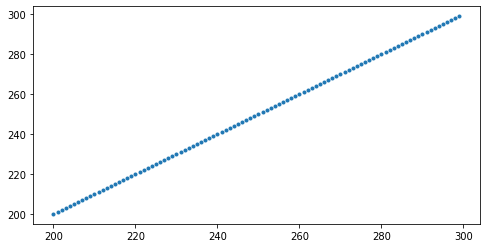

In [45]:
plt.plot(cf.time_data, cf.time_data, ".")

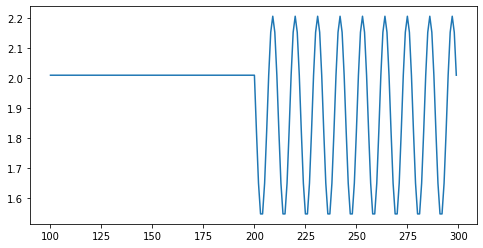

In [46]:
plt.plot(jnp.arange(100, 300), sine(jnp.arange(100, 300)))

In [47]:
%%time
soln = cf.fit_cp(low_bound=0.)

CPU times: user 11min 24s, sys: 2.77 s, total: 11min 27s
Wall time: 10min 35s


In [48]:
soln.message

'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'

In [49]:
print("total likelihood: ", cf.gp_likelihood(soln.x))
print("gp likelihood: ", cf.gp_neg_log_likelihood(soln.x))
print("chi2: ", cf.loss_chi2(soln.x))

total likelihood:  79.81903229152107
gp likelihood:  79.7818738544695
chi2:  0.03715843705158016


Text(0.5, 1.0, 'sine production rate')

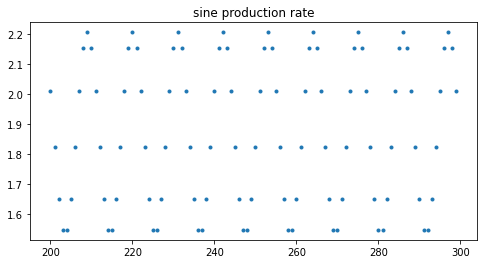

In [50]:
t = cf.control_points_time
true_cp = sine(t)
plt.plot(t, sine(t), ".")
plt.title('sine production rate')

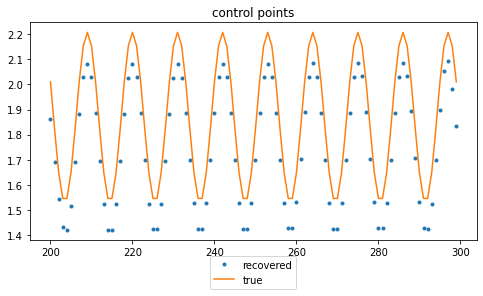

In [51]:
plt.plot(t, soln.x[:-1], ".", label="recovered")
plt.plot(t, true_cp, label='true')
plt.title("control points");
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True)

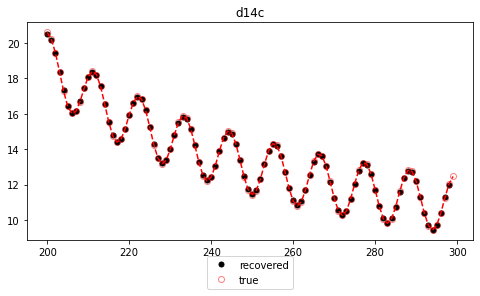

In [52]:
plt.plot(cf.time_data[:-1], cf.dc14(soln.x), ".k", label="recovered", markersize=10)
plt.plot(cf.time_data, cf.d14c_data, '--r')
plt.plot(cf.time_data, cf.d14c_data, 'or', fillstyle="none", label="true", alpha=0.5)
plt.title("d14c");
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True)

In [53]:
fit = cf.production(np.arange(100, cf.end), (soln.x))

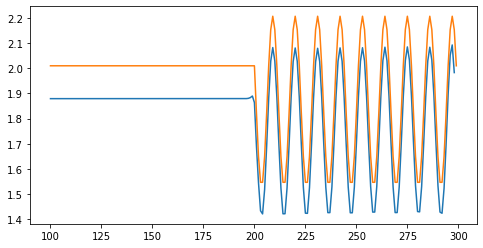

In [54]:
plt.plot(np.arange(100, cf.end), fit)
plt.plot(jnp.arange(100, 300), sine(jnp.arange(100, 300)))